In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
sns.set_context('talk',font_scale=1)

In [2]:
### SET UP INITIAL FEATURES ###

# get all data, remove useless rows, and organize
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain.reset_index(drop= True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Xtrain.loc[index, 'Visit'] = '1 Month'

# summarize features, separating by subject-visit bootstrapped sample and pair with MDS scores and Baseline MDS scores
features = pd.DataFrame()
for s in Xtrain['Subject'].unique():
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        
        # get the MDS and Baseline MDS scores
        mds = float('Nan')
        baseline_mds = float('Nan')
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        # skip visit if no actual or baseline mds score is available
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            continue

        # create new features dataframe usin bootstrapping to augment data
        vtrain = vtrain.iloc[:, 5:-2]
        columns = vtrain.columns.values.tolist()
        # create 200 bootstrapped samples per subject-visit, each bootstrapped sample is 10% of the original data
        for i in range(200):
            cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
            vals = [s, mds, v, baseline_mds]
            sample = vtrain.sample(frac = 0.1, replace = False)
            for c in columns:
                cols.append(c + " mean")
                cols.append(c + " var")
                vals.append(sample[c].mean())
                vals.append(sample[c].var())
            df = pd.DataFrame(data = [vals], columns = cols)
            features = features.append(df, ignore_index = True)
            
# organize data
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
# remove rows with null values (because regression will not work)
features = features.dropna()
features.Subject.unique()

array([1016, 1018, 1019, 1023, 1024, 1029, 1030, 1032, 1038, 1039, 1043,
       1044, 1046, 1049, 1051], dtype=int64)

In [3]:
### CALCULATE THE FIRST STACK ###

# setup needed variables
a = []; b = []; v = []; subjs = []
pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []

# use a leave one subject out approach to train the models
for s in features['Subject'].unique():

    # setup regressors
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # split the training and test data (LOSO)
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 0)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # scale the training data
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train the regressors
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    # set up test data
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 0)]
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and store in stacked_predictions dataframe
    if (len(Xtest) != 0):
        # scale the test data
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred KNR
subj,1.000000,-0.081644,0.307243,0.347253,0.171226,0.230139,0.230402
actual mds,-0.081644,1.000000,0.578878,-0.023699,0.072298,-0.220060,-0.039663
baseline mds,0.307243,0.578878,1.000000,0.121951,0.056227,0.026623,0.025412
pred RFR,0.347253,-0.023699,0.121951,1.000000,0.408461,0.318278,0.461076
pred NN,0.171226,0.072298,0.056227,0.408461,1.000000,0.182571,0.338192
pred LN,0.230139,-0.220060,0.026623,0.318278,0.182571,1.000000,0.334824
pred KNR,0.230402,-0.039663,0.025412,0.461076,0.338192,0.334824,1.000000


In [4]:
### CALCULATE FINAL PREDICTIONS FROM THE FIRST STACK ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []; 
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out approach to train models
for s in stacked_predictions['subj'].unique():
    
    # split train and test data
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    # scale train and test data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # fit regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
# build new predictions dataframe
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.081644,-0.179224,0.150822,0.372483,0.372483,0.053484
actual mds,-0.081644,1.000000,0.134315,0.293757,0.475743,0.475743,0.317520
pred RFR,-0.179224,0.134315,1.000000,0.617160,0.527713,0.527713,0.706378
pred NN,0.150822,0.293757,0.617160,1.000000,0.578074,0.578074,0.830756
pred LN,0.372483,0.475743,0.527713,0.578074,1.000000,1.000000,0.605796
pred LARS,0.372483,0.475743,0.527713,0.578074,1.000000,1.000000,0.605796
pred KNR,0.053484,0.317520,0.706378,0.830756,0.605796,0.605796,1.000000


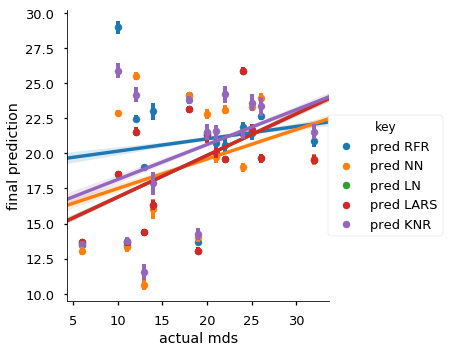

In [5]:
### PLOT FINAL PREDICTIONS FROM FIRST STACK ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[2:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.13431453596994805
RMSE: 7.760644634491206


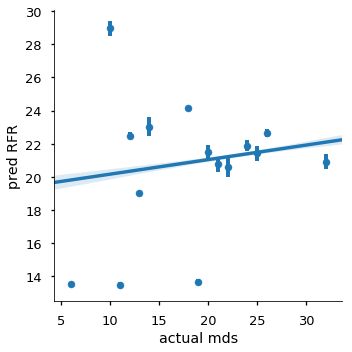

In [6]:
### 1 stack followed by RFR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred RFR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred RFR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.29375672072187
RMSE: 7.081995205927101


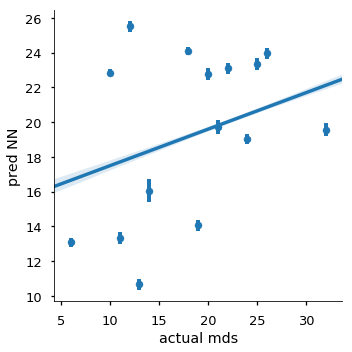

In [7]:
### 1 stack followed by NN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred NN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred NN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.47574302281211284
RMSE: 6.054403645914524


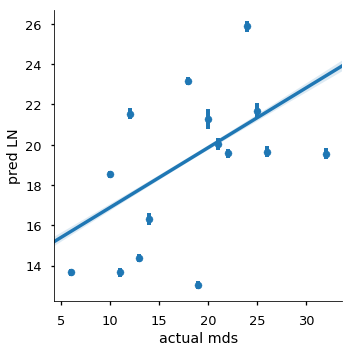

In [8]:
### 1 stack followed by LN ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LN'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LN'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.475743022812112
RMSE: 6.054403645914528


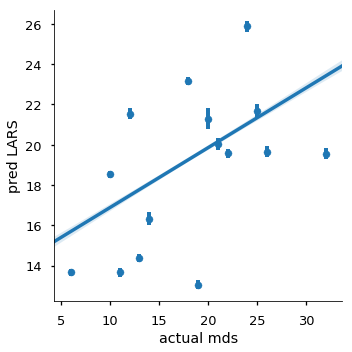

In [9]:
### 1 stack followed by LARS ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred LARS'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred LARS'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1, x_estimator=np.mean)

correlation coefficient: 0.3175202941304497
RMSE: 7.247633418388844


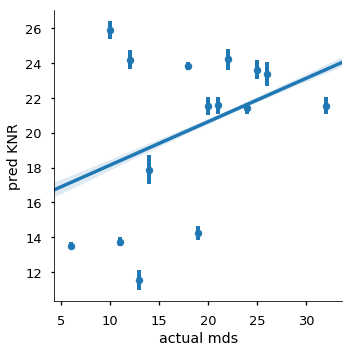

In [10]:
### 1 stack followed by KNR ###
print('correlation coefficient: ' + np.corrcoef(second_stack_predictions['actual mds'], second_stack_predictions['pred KNR'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(second_stack_predictions['actual mds'].values) - np.array(second_stack_predictions['pred KNR'].values))**2))).__str__()) 
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1, x_estimator=np.mean)

In [11]:
### CALCULATE SECOND STACK FROM FIRST STACK - WITHOUT BASELINE ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use leave one subject out method to train models
for s in stacked_predictions['subj'].unique():
    # split test and train groups
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
# build second feature matrix
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.081644,0.307243,-0.056191,-0.065907,-0.059255,-0.059255,-0.043322
actual mds,-0.081644,1.000000,0.578878,-0.067104,-0.074454,-0.222112,-0.222112,-0.064707
baseline mds,0.307243,0.578878,1.000000,-0.153202,-0.188583,-0.321272,-0.321272,-0.133645
pred RFR,-0.056191,-0.067104,-0.153202,1.000000,0.735460,0.440576,0.440576,0.721252
pred NN,-0.065907,-0.074454,-0.188583,0.735460,1.000000,0.546053,0.546053,0.658706
pred LN,-0.059255,-0.222112,-0.321272,0.440576,0.546053,1.000000,1.000000,0.363834
pred LARS,-0.059255,-0.222112,-0.321272,0.440576,0.546053,1.000000,1.000000,0.363834
pred KNR,-0.043322,-0.064707,-0.133645,0.721252,0.658706,0.363834,0.363834,1.000000


,subj,actual mds,final prediction
subj,1.000000,-0.081644,-0.059895
actual mds,-0.081644,1.000000,0.560225
final prediction,-0.059895,0.560225,1.000000


num data points: 4200
correlation coefficient: 0.5602248219565281
RMSE: 5.78596006876282
Cohen Kappa Score: 0.06777994893127293


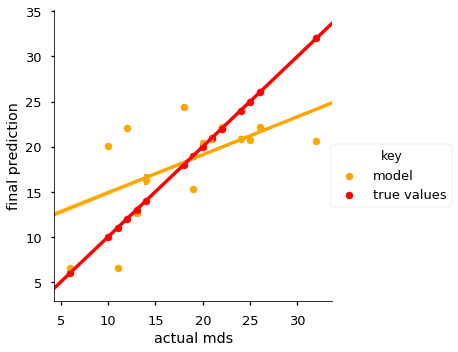

In [12]:
### CALCULATE FINAL PREDICTIONS FROM SECOND STACK ###

# create regressors
#clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
#        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]
clfs = [MLPRegressor(max_iter = 10000, random_state = 2)]

# display results for each regressor
for clf_final in clfs:
    # setup
    actual_mds = []; predictions_final = []; subjs3 = []
    
    # train models using leave one subject out method
    for s in second_stack_predictions['subj'].unique():

        # split test train data
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
        
        # scale data
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
        
        # train regressor
        clf_final.fit(second_stack_train, second_stack_ytrain)
        
        # make predictions and store in predictions dataframe
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test))
            subjs3 += [s for elem in list(second_stack_ytest)]
    # build predictions dataframe and display results
    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    # display results
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'

    print("num data points: " + len(predictions.index.values).__str__())
    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in predictions['final prediction'].values], [int(p) for p in predictions['actual mds']]).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    colors = {'model': 'orange', 'true values': 'r'}
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator= np.mean, palette = colors)
    plt.show()